In [26]:
import glob
import numpy as np
import os
import matplotlib.pyplot as plt

import time

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models, utils

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
test_path = os.path.join('data','training-dataset','latest_training_data1','*')
test_images = glob.glob(test_path)
for name in test_images:
    print(name)

data\training-dataset\latest_training_data1\BreastHistoTTD_1.png
data\training-dataset\latest_training_data1\BreastHistoTTD_10.png
data\training-dataset\latest_training_data1\BreastHistoTTD_100.png
data\training-dataset\latest_training_data1\BreastHistoTTD_1000.png
data\training-dataset\latest_training_data1\BreastHistoTTD_1001.png
data\training-dataset\latest_training_data1\BreastHistoTTD_1002.png
data\training-dataset\latest_training_data1\BreastHistoTTD_1003.png
data\training-dataset\latest_training_data1\BreastHistoTTD_1004.png
data\training-dataset\latest_training_data1\BreastHistoTTD_1005.png
data\training-dataset\latest_training_data1\BreastHistoTTD_1006.png
data\training-dataset\latest_training_data1\BreastHistoTTD_1007.png
data\training-dataset\latest_training_data1\BreastHistoTTD_1008.png
data\training-dataset\latest_training_data1\BreastHistoTTD_1009.png
data\training-dataset\latest_training_data1\BreastHistoTTD_101.png
data\training-dataset\latest_training_data1\BreastHisto

In [18]:
df_test = pd.DataFrame({'image_path':test_images})

In [30]:
df_test['Id'] = df_test['image_path'].map(lambda x: x.split("\\")[-1].split('.')[0])
df_test = df_test.iloc[:200]

df_test.shape

(200, 2)

In [20]:
df_test.head()

,image_path,Id
0,data\training-dataset\latest_training_data1\Br...,BreastHistoTTD_1
1,data\training-dataset\latest_training_data1\Br...,BreastHistoTTD_10
2,data\training-dataset\latest_training_data1\Br...,BreastHistoTTD_100
3,data\training-dataset\latest_training_data1\Br...,BreastHistoTTD_1000
4,data\training-dataset\latest_training_data1\Br...,BreastHistoTTD_1001


In [21]:
class GenomeDataset(Dataset):
    def __init__(self, df, transform = None, training=True):
        self.df = df
        self.len = len(self.df)
        self.transform = transform
        self.training = training
        self.normalize = transforms.Normalize(
                         mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]
                      )
        self.toTensor = transforms.Compose([transforms.ToTensor(), self.normalize])
        
    def __len__(self):
        return self.len
    
    def get_random_number(self):
        return random.randint(0,self.len-1)
    
    def __getitem__(self,idx):
        img = Image.open(self.df.iloc[idx].loc['image_path'])
        
        if self.transform:
            img = self.transform(img)
            
        img = self.toTensor(img)
            
        if self.training:    
            label = self.df.iloc[idx].loc['label']
            return img,  label
        else:
            return img

In [31]:
# normalize = transforms.Normalize(
#    mean=[0.5, 0.5, 0.5],
#    std=[0.5, 0.5, 0.5]
# )

# trans_train = transforms.Compose([
#     transforms.Resize([224,224]),
# #     transforms.Pad(64, padding_mode='reflect'),
#     transforms.RandomHorizontalFlip(),   
#     transforms.RandomVerticalFlip(),   
#     transforms.RandomRotation(20),
# #     transforms.RandomCrop(224),
#     transforms.ToTensor(),
#     normalize
# ])

trans_test = transforms.Compose([
    transforms.Resize([224,224]),
#     transforms.ToTensor(),
#     normalize
])

# train_ds = GenomeDataset(df_train, transform=imgaug_transforms)
# val_ds = GenomeDataset(df_val, transform=trans_test)
test_ds = GenomeDataset(df_test, transform=trans_test, training=False)

# train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
# val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=32, num_workers=0)

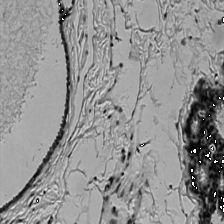

In [32]:
toPIL = transforms.ToPILImage()
toPIL(test_ds[3][0])

In [27]:
model = models.densenet161(pretrained=False)

num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 2)
        )

model = model.to(device)

In [28]:
model_path = os.path.join('model','densenet_100.pth')

model.load_state_dict(torch.load(model_path))

In [34]:
def predict():
    model.eval()  
    y_pred=[]

    with torch.no_grad():
        correct = 0
        total = 0
        for images in test_dl:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            y_pred+=list(predicted.cpu().numpy())
    return y_pred


In [36]:
start_time = time.time()
predictions = predict()
print('Prediction time: {:10f} minutes'.format((time.time()-start_time)/60))

Prediction time:   0.064567 minutes


In [38]:
len(predictions)

200

In [39]:
df_test['Classification'] = predictions

In [41]:
df_test.head()

,image_path,Id,Classification
0,data\training-dataset\latest_training_data1\Br...,BreastHistoTTD_1,1
1,data\training-dataset\latest_training_data1\Br...,BreastHistoTTD_10,1
2,data\training-dataset\latest_training_data1\Br...,BreastHistoTTD_100,1
3,data\training-dataset\latest_training_data1\Br...,BreastHistoTTD_1000,1
4,data\training-dataset\latest_training_data1\Br...,BreastHistoTTD_1001,1
